Loading MoSeq results from 2025_11_16-22_50_50...
Match Found: Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_familiarOct19shuffle1_snapshot_200_el_mouse1

--- Instance Details ---
Video Time: 23.83s
EEG Time:   26.11s
Zoom Window: 21.11s - 32.28s
Total EEG Duration: 909.23s


/var/folders/6d/qxbzy_1n5dn6bmb401phk99r0000gn/T/ipykernel_38050/3476899586.py:114: RuntimeWarning:

All-NaN slice encountered

/var/folders/6d/qxbzy_1n5dn6bmb401phk99r0000gn/T/ipykernel_38050/3476899586.py:115: RuntimeWarning:

All-NaN slice encountered

/var/folders/6d/qxbzy_1n5dn6bmb401phk99r0000gn/T/ipykernel_38050/3476899586.py:188: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



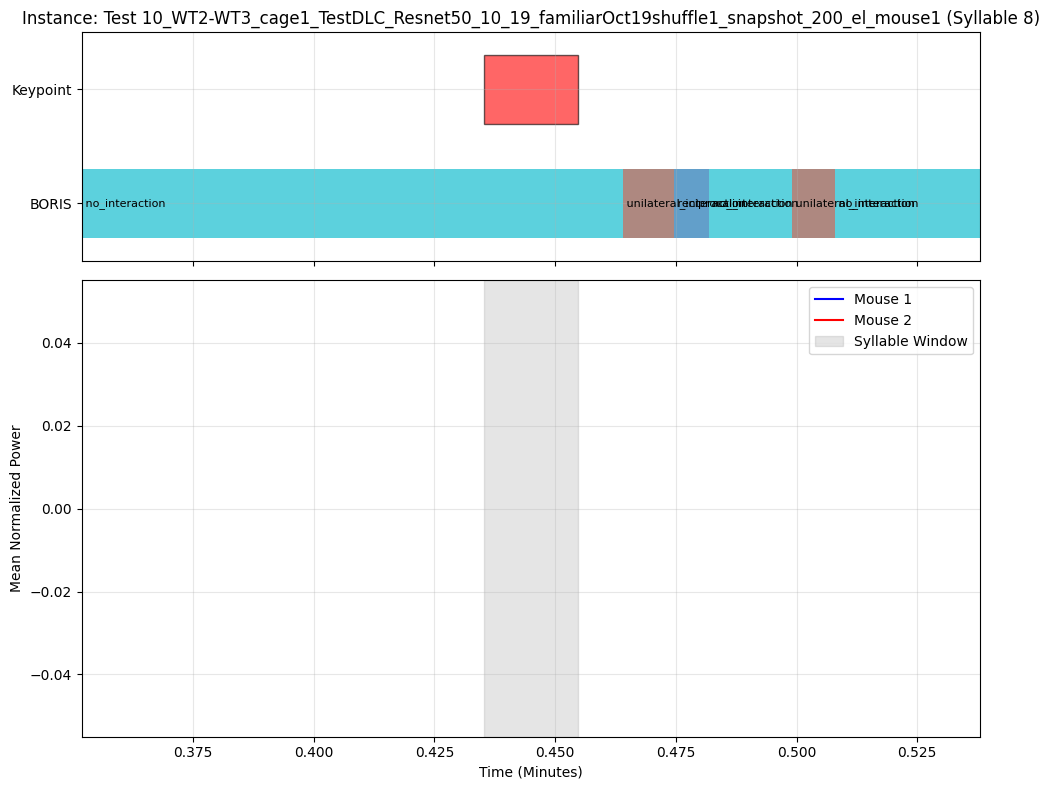

In [15]:
import sys
import subprocess
import os

try:
    import openpyxl
except ImportError:
    print("Installing missing dependency 'openpyxl'...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    print("Installed openpyxl. Continuing...")

import keypoint_moseq as kpms
import pandas as pd
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt
from itertools import groupby

project_dir = '/Users/yinazhou/DeepLabCut/examples/DeepLabCut/examples/11_1_identity_true'
model_name = '2025_11_16-22_50_50' 
boris_eeg_root = '/Users/yinazhou/DeepLabCut/examples/boris_and_eeg'

TARGET_SYLLABLE = 8
FPS = 30
OFFSET = 2.28  

# show 5 seconds before/after the event
BUFFER_SEC = 5.0  

# eeg settings
CHANNEL_M1 = 0  
CHANNEL_M2 = 1 
FS_EXPECTED = 1000

#power calc
WIN_SEC = 2.0
STEP_SEC = 0.5
SENSITIVITY_FACTOR = 25 

#hmmmm
def normalize_boris_columns(df):
    col_map = {
        'start_time': 'Start', 'Start_Time_s_': 'Start', 'Start time': 'Start',
        'end_time': 'End', 'End_time_s_': 'End', 'End time': 'End',
        'Label': 'Label', 'behavior': 'Label'
    }
    df = df.rename(columns=col_map)
    required = ['Start', 'End', 'Label']
    if not all(col in df.columns for col in required):
        return pd.DataFrame() 
    return df

def find_associated_files(recording_key, root_dir):
    clean_name = recording_key.replace('_mouse1', '').replace('_mouse2', '')
    folder_prefix = clean_name.split('_')[0] 
    target_folder = os.path.join(root_dir, folder_prefix)
    
    if not os.path.exists(target_folder): return None, None

    mat_path = None
    boris_path = None
    for f in os.listdir(target_folder):
        if f.endswith('.mat'): mat_path = os.path.join(target_folder, f)
        elif f.endswith('.xlsx') and not f.startswith('~$'): boris_path = os.path.join(target_folder, f)
            
    return mat_path, boris_path

def load_eeg_data(mat_path):
    try:
        mat = scipy.io.loadmat(mat_path)
        keys = [k for k in mat.keys() if not k.startswith('__')]
        data_struct = mat[keys[0]]
        eeg_data = data_struct['F'][0,0]      
        eeg_time = data_struct['Time'][0,0].flatten()
        eeg_time = eeg_time - eeg_time[0] 
        return eeg_data, eeg_time
    except Exception as e:
        print(f"Error loading MAT file: {e}")
        return None, None

def calculate_normalized_power(data, fs):
    # 0. Clean NaNs (Critical step for empty plots)
    if np.any(np.isnan(data)):
        print("  ! Warning: NaNs detected in raw EEG. Replacing with zero.")
        data = np.nan_to_num(data, nan=0.0)

    b_notch, a_notch = iirnotch(60.0, 30.0, fs)
    data = filtfilt(b_notch, a_notch, data)
    nyquist = 0.5 * fs
    b_band, a_band = butter(4, [2.0/nyquist, 12.0/nyquist], btype='band')
    data_filt = filtfilt(b_band, a_band, data)

    win_samples = int(WIN_SEC * fs)
    step_samples = int(STEP_SEC * fs)
    
    if len(data_filt) < win_samples:
        print("  ! Error: EEG data shorter than window size.")
        return np.array([]), np.array([])

    num_windows = (len(data_filt) - win_samples) // step_samples + 1
    
    power = np.zeros(num_windows)
    power_time = np.zeros(num_windows)
    
    for i in range(num_windows):
        start_idx = i * step_samples
        end_idx = start_idx + win_samples
        window = data_filt[start_idx:end_idx]
        power[i] = np.mean(window**2)
        power_time[i] = (start_idx + win_samples/2) / fs

    #outlier removal
    median_val = np.nanmedian(power)
    mad = np.nanmedian(np.abs(power - median_val))
    threshold = SENSITIVITY_FACTOR * mad 
    
    outliers = np.abs(power - median_val) > threshold
    if np.any(outliers): 
        power[outliers] = median_val 
    
    norm_factor = np.percentile(power, 99)
    if norm_factor == 0: norm_factor = 1
    
    return power / norm_factor, power_time

def plot_integrated_instance(rec_key, start_f, end_f, mat_path, boris_path):
    vid_start_s = start_f / FPS
    vid_end_s = end_f / FPS
    
    win_start_vid = vid_start_s - BUFFER_SEC
    win_end_vid = vid_end_s + BUFFER_SEC
    
    win_start_eeg = win_start_vid + OFFSET
    win_end_eeg = win_end_vid + OFFSET
    syll_start_eeg = vid_start_s + OFFSET
    syll_end_eeg = vid_end_s + OFFSET

    print(f"\n--- Instance Details ---")
    print(f"Video Time: {vid_start_s:.2f}s")
    print(f"EEG Time:   {syll_start_eeg:.2f}s")
    print(f"Zoom Window: {win_start_eeg:.2f}s - {win_end_eeg:.2f}s")

    raw_data, time_vec = load_eeg_data(mat_path)
    if raw_data is None: return
    
    total_duration = time_vec[-1]
    print(f"Total EEG Duration: {total_duration:.2f}s")
    if win_end_eeg > total_duration:
        print(f"WARNING: Requested window end ({win_end_eeg:.2f}s) is AFTER EEG ends ({total_duration:.2f}s)!")
        print("The plot might be blank because the event happens after the recording stopped.")

    fs_est = 1 / np.mean(np.diff(time_vec))
    
    pow_m1, t_pow = calculate_normalized_power(raw_data[CHANNEL_M1, :], fs_est)
    pow_m2, _     = calculate_normalized_power(raw_data[CHANNEL_M2, :], fs_est)

    if len(pow_m1) == 0:
        print("Power calculation failed (data too short or empty).")
        return

    # process BORIS
    relevant_boris = pd.DataFrame()
    try:
        boris_df = pd.read_excel(boris_path, engine='openpyxl')
        boris_df = normalize_boris_columns(boris_df)
        if not boris_df.empty:
            boris_df['Start_EEG'] = boris_df['Start'] + OFFSET
            boris_df['End_EEG'] = boris_df['End'] + OFFSET
            relevant_boris = boris_df[
                (boris_df['End_EEG'] > win_start_eeg) & 
                (boris_df['Start_EEG'] < win_end_eeg)
            ]
    except Exception: pass

    # --------plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
    
    # BEHVORIOS
    ax1.set_title(f'Instance: {rec_key} (Syllable {TARGET_SYLLABLE})')
    
    # keypoint syllable
    ax1.barh(y=1, width=(syll_end_eeg - syll_start_eeg)/60, left=syll_start_eeg/60, 
             color='red', edgecolor='black', height=0.6, label='MoSeq Syllable', alpha=0.6)
    
    # boris labels
    unique_labels = relevant_boris['Label'].unique() if not relevant_boris.empty else []
    colors = plt.cm.get_cmap('tab10', len(unique_labels) if len(unique_labels) > 0 else 1)
    for idx, row in relevant_boris.iterrows():
        c_idx = list(unique_labels).index(row['Label'])
        ax1.barh(y=0, width=(row['End_EEG'] - row['Start_EEG'])/60, left=row['Start_EEG']/60, 
                 color=colors(c_idx), alpha=0.7, height=0.6)
        ax1.text(max(row['Start_EEG'], win_start_eeg)/60, 0, f" {row['Label']}", va='center', fontsize=8)

    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['BORIS', 'Keypoint'])
    ax1.set_ylim(-0.5, 1.5)
    ax1.grid(True, alpha=0.3)

    # POWER
    ax2.plot(t_pow/60, pow_m1, 'b-', linewidth=1.5, label='Mouse 1')
    ax2.plot(t_pow/60, pow_m2, 'r-', linewidth=1.5, label='Mouse 2')
    ax2.axvspan(syll_start_eeg/60, syll_end_eeg/60, color='gray', alpha=0.2, label='Syllable Window')
    
    ax2.set_ylabel('Mean Normalized Power')
    ax2.set_xlabel('Time (Minutes)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    ax2.set_xlim(win_start_eeg/60, win_end_eeg/60)
    
    plt.tight_layout()
    plt.show()

print(f"Loading MoSeq results from {model_name}...")
results = kpms.load_results(project_dir, model_name)
found = False

for key, data in results.items():
    syllables = data['syllable']
    curr_idx = 0
    for syll_id, group in groupby(syllables):
        duration = len(list(group))
        if syll_id == TARGET_SYLLABLE:
            start_frame, end_frame = curr_idx, curr_idx + duration
            mat_file, boris_file = find_associated_files(key, boris_eeg_root)
            if mat_file and boris_file:
                print(f"Match Found: {key}")
                plot_integrated_instance(key, start_frame, end_frame, mat_file, boris_file)
                found = True
                break 
        curr_idx += duration
    if found: break
if not found: print(f"No match found for Syllable {TARGET_SYLLABLE}.")